### **Exercise B — Association Rules with PySpark**

####  Step 1: Initialize Spark and Load the Dataset

In [23]:
from pyspark import SparkContext
import csv

sc = SparkContext(appName="AssociationRules")

### **Step 2: Read and Parse the Dataset**

Read the `conditions.csv` file, parse it using the CSV reader, and filter out the header and malformed lines.

In [24]:
def parse_csv(line):
    """Parse a CSV line into fields"""
    try:
        return next(csv.reader([line]))
    except:
        return None
    
lines = sc.textFile("conditions.csv")
header = lines.first()
data = lines.filter(lambda x: x != header).map(parse_csv).filter(lambda x: x is not None)
code_description_rdd = data.map(lambda x: (x[4], x[5])).distinct()
code_description = dict(code_description_rdd.collect())

### **Step 3: Build (PATIENT, set(CODE)) Baskets**

Group condition codes by patient, forming a set of conditions for each.

In [25]:
patient_conditions = data.map(lambda x: (x[2], x[4])) \
                         .groupByKey() \
                         .mapValues(lambda codes: set(codes))

total_patients = patient_conditions.count()

### **Step 4: Count Frequent 1-Itemsets (Single Conditions)**

Count the frequency of each individual condition code.

In [26]:
item_counts = patient_conditions.flatMap(lambda x: [(item, 1) for item in x[1]]) \
                                 .reduceByKey(lambda a, b: a + b) \
                                 .collectAsMap()

### **Step 5: Count Frequent 2-Itemsets (Condition Pairs)**

Generate all unordered 2-item combinations per patient and count occurrences.

In [27]:
def generate_2_itemsets(conditions):
    items = list(conditions)
    return [(tuple(sorted([items[i], items[j]])), 1) for i in range(len(items)) for j in range(i+1, len(items))]

pair_counts = patient_conditions.flatMap(lambda x: generate_2_itemsets(x[1])) \
                                .reduceByKey(lambda a, b: a + b) \
                                .collectAsMap()

### **Step 6: Count Frequent 3-Itemsets (Condition Triplets)**

Generate triplets of conditions.

In [28]:
def generate_3_itemsets(conditions):
    items = list(conditions)
    return [(tuple(sorted([items[i], items[j], items[k]])), 1)
            for i in range(len(items))
            for j in range(i+1, len(items))
            for k in range(j+1, len(items))]

triple_counts = patient_conditions.flatMap(lambda x: generate_3_itemsets(x[1])) \
                                   .reduceByKey(lambda a, b: a + b) \
                                   .collectAsMap()

### **Step 7: Apply Support Threshold and Sanity Checks**

Filter itemsets with a support greater than or equal to 1000.

In [29]:
support_threshold = 1000

frequent_items = [item for item, count in item_counts.items() if count >= support_threshold]
frequent_pairs = [(pair, count) for pair, count in pair_counts.items() if count >= support_threshold]
frequent_triples = [(triple, count) for triple, count in triple_counts.items() if count >= support_threshold]

print("Count of frequent 1-itemsets:", len(frequent_items))
print("Count of frequent 2-itemsets:", len(frequent_pairs))
print("Count of frequent 3-itemsets:", len(frequent_triples))

# Top frequent pairs/triples
top_3_pairs = sorted(frequent_pairs, key=lambda x: -x[1])
top_4_triples = sorted(frequent_triples, key=lambda x: -x[1])

if len(top_3_pairs) >= 3:
    print("3rd most frequent pair:", top_3_pairs[2][0])

if len(top_4_triples) >= 4:
    print("4th most frequent triplet:", top_4_triples[3][0])

Count of frequent 1-itemsets: 131
Count of frequent 2-itemsets: 2940
Count of frequent 3-itemsets: 13395
3rd most frequent pair: ('15777000', '271737000')
4th most frequent triplet: ('10509002', '15777000', '271737000')


### **Frequent 1-itemsets (Condition Descriptions with Support ≥ 1000)**

In [30]:
for code in frequent_items:
    desc = code_description.get(code, code)
    print(f"{desc} ({code}): {item_counts[code]}")

Sinusitis (disorder) (36971009): 66530
Streptococcal sore throat (disorder) (43878008): 153069
Child attention deficit disorder (192127007): 18394
Diabetic retinopathy associated with type II diabetes mellitus (disorder) (422034002): 20456
Chronic pain (82423001): 54974
Alcoholism (7200002): 10092
Preeclampsia (398254007): 22959
Recurrent urinary tract infection (197927001): 10121
History of appendectomy (428251008): 53933
Diabetic renal disease (disorder) (127013003): 34609
Overlapping malignant neoplasm of colon (109838007): 8153
Seizure disorder (128613002): 42693
Neoplasm of prostate (126906006): 28954
Cardiac Arrest (410429000): 43157
Bullet wound (262574004): 7629
Chronic obstructive bronchitis (disorder) (185086009): 16727
Brain damage - traumatic (275272006): 7265
Injury of medial collateral ligament of knee (444448004): 8650
Fracture of vertebral column without spinal cord injury (15724005): 1399
Body mass index 30+ - obesity (finding) (162864005): 365567
Proliferative diabeti

### **Frequent 2-itemsets (Condition Pairs with Support ≥ 1000)**

In [31]:
for (code1, code2), count in frequent_pairs:
    desc1 = code_description.get(code1, code1)
    desc2 = code_description.get(code2, code2)
    print(f"({desc1} [{code1}], {desc2} [{code2}]): {count}")

(Miscarriage in first trimester [19169002], Sinusitis (disorder) [36971009]): 12050
(Acute allergic reaction [241929008], Viral sinusitis (disorder) [444814009]): 9494
(Perennial allergic rhinitis with seasonal variation [232353008], Acute allergic reaction [241929008]): 4025
(History of single seizure (situation) [703151001], Sprain of wrist [70704007]): 1850
(Stroke [230690007], Osteoarthritis of hip [239872002]): 2386
(Prediabetes [15777000], Viral sinusitis (disorder) [444814009]): 236320
(First degree burn [403190006], Hyperlipidemia [55822004]): 3241
(Miscarriage in first trimester [19169002], Diabetic retinopathy associated with type II diabetes mellitus (disorder) [422034002]): 5455
(Miscarriage in first trimester [19169002], Streptococcal sore throat (disorder) [43878008]): 20772
(Hypertriglyceridemia (disorder) [302870006], Polyp of colon [68496003]): 9835
(Metabolic syndrome X (disorder) [237602007], Hypertriglyceridemia (disorder) [302870006]): 74395
(Diabetic renal disease

### **Frequent 3-itemsets (Condition Triplets with Support ≥ 1000)**

In [32]:
for (code1, code2, code3), count in frequent_triples:
    desc1 = code_description.get(code1, code1)
    desc2 = code_description.get(code2, code2)
    desc3 = code_description.get(code3, code3)
    print(f"({desc1} [{code1}], {desc2} [{code2}], {desc3} [{code3}]): {count}")

(Sinusitis (disorder) [36971009], Chronic sinusitis (disorder) [40055000], Osteoporosis (disorder) [64859006]): 2268
(Acute bronchitis (disorder) [10509002], Anemia (disorder) [271737000], Chronic sinusitis (disorder) [40055000]): 39326
(Prediabetes [15777000], Miscarriage in first trimester [19169002], Acute viral pharyngitis (disorder) [195662009]): 41106
(Acute viral pharyngitis (disorder) [195662009], Anemia (disorder) [271737000], Osteoporosis (disorder) [64859006]): 11589
(Acute bronchitis (disorder) [10509002], Seizure disorder [128613002], History of single seizure (situation) [703151001]): 15802
(Streptococcal sore throat (disorder) [43878008], Viral sinusitis (disorder) [444814009], Perennial allergic rhinitis [446096008]): 3224
(Body mass index 30+ - obesity (finding) [162864005], Osteoarthritis of hip [239872002], Anemia (disorder) [271737000]): 3428
(Acute bronchitis (disorder) [10509002], Stroke [230690007], Anemia (disorder) [271737000]): 11482
(Osteoarthritis of hip [23

### **Step 8: Visualize Frequent Itemset Counts**

Visualize the top 10 most frequent condition codes.

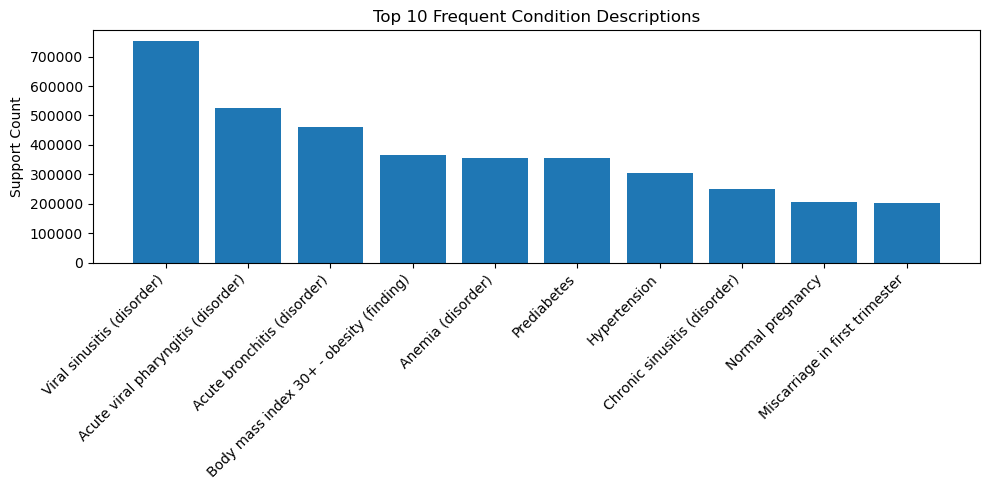

In [33]:
import matplotlib.pyplot as plt

top_items = sorted(item_counts.items(), key=lambda x: -x[1])[:10]
codes, counts = zip(*top_items)
descriptions = [code_description.get(code, code) for code in codes]

plt.figure(figsize=(10, 5))
plt.bar(descriptions, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Frequent Condition Descriptions")
plt.ylabel("Support Count")
plt.tight_layout()
plt.show()

### **Step 9: Generate Association Rules**

Generate rules of the form:
- **(X) → Y**
- **(X, Y) → Z**

with **Standardized Lift ≥ 0.2**.

In [34]:
rules = []

# (X) -> Y
for (X, Y), suppXY in pair_counts.items():
    if suppXY < support_threshold:
        continue

    suppX = item_counts.get(X, 1)
    suppY = item_counts.get(Y, 1)

    confidence = suppXY / suppX
    support_X = suppX / total_patients
    support_Y = suppY / total_patients
    support_XY = suppXY / total_patients

    lift = confidence / support_Y
    interest = support_XY - (support_X * support_Y)
    denominator = (max(support_X, support_Y) / (support_X * support_Y)) - 1
    standardized_lift = (lift - 1) / denominator if denominator != 0 else 0

    if standardized_lift >= 0.2:
        rules.append(((X,), Y, standardized_lift, lift, confidence, interest))

# (X,Y) -> Z
for (X, Y, Z), suppXYZ in triple_counts.items():
    if suppXYZ < support_threshold:
        continue

    suppXY = pair_counts.get((X, Y), 1)

    confidence = suppXYZ / suppXY
    support_XY = suppXY / total_patients
    support_Z = item_counts.get(Z, 1) / total_patients
    support_XYZ = suppXYZ / total_patients

    lift = confidence / support_Z
    interest = support_XYZ - (support_XY * support_Z)
    denominator = (max(support_XY, support_Z) / (support_XY * support_Z)) - 1
    standardized_lift = (lift - 1) / denominator if denominator != 0 else 0

    if standardized_lift >= 0.2:
        rules.append(((X, Y), Z, standardized_lift, lift, confidence, interest))

### **Step 10: Display Top Rules**

Sort rules by **standardized lift** and display the top ones in a table.

In [35]:
import pandas as pd

rules_sorted = sorted(rules, key=lambda x: -x[2])

def describe(item):
    if isinstance(item, tuple):
        return tuple(code_description.get(code, code) for code in item)
    return code_description.get(item, item)

rules_described = [
    (describe(antecedent), describe(consequent), s_lift, lift, conf, interest)
    for antecedent, consequent, s_lift, lift, conf, interest in rules_sorted
]

df_rules = pd.DataFrame(
    rules_described,
    columns=["Antecedent", "Consequent", "Standardized Lift", "Lift", "Confidence", "Interest"]
)
df_rules.head(10)

,Antecedent,Consequent,Standardized Lift,Lift,Confidence,Interest
0,"(Cholelithiasis,)",Acute Cholecystitis,1.000000,433.874813,1.000000,0.002300
1,"(History of appendectomy,)",Appendicitis,1.000000,21.463260,1.000000,0.044421
2,"(Myocardial Infarction,)",History of myocardial infarction (situation),1.000000,46.918693,1.000000,0.020859
3,"(Cardiac Arrest,)",History of cardiac arrest (situation),1.000000,26.822485,1.000000,0.035892
4,"(Seizure disorder,)",History of single seizure (situation),1.000000,27.114000,1.000000,0.035521
5,"(Protracted diarrhea,)",Bleeding from anus,1.000000,261.777024,1.000000,0.003805
6,"(Non-small cell lung cancer (disorder),)",Non-small cell carcinoma of lung TNM stage 1 ...,0.999683,90.783311,0.999686,0.010890
7,"(Suspected lung cancer (situation), Non-small ...",Non-small cell carcinoma of lung TNM stage 1 ...,0.999683,90.783311,0.999686,0.010890
8,"(Small cell carcinoma of lung (disorder),)",Primary small cell malignant neoplasm of lung ...,0.999555,514.479111,0.999556,0.001939
9,"(Suspected lung cancer (situation), Small cell...",Primary small cell malignant neoplasm of lung ...,0.999555,514.479111,0.999556,0.001939


### **Step 11: Save Rules to File**

Optionally write the rules to a `.txt` file.

In [36]:
with open("association_rules.txt", "w") as f:
    for antecedent, consequent, s_lift, lift, conf, interest in rules_described:
        antecedent_str = ", ".join(antecedent)
        f.write(f"{antecedent_str} -> {consequent} | Standardized Lift: {s_lift:.4f} | Lift: {lift:.4f} | Confidence: {conf:.4f} | Interest: {interest:.6f}\n")

sc.stop()